In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from pycbc import psd as psd_func
from pycbc.filter import overlap_cplx
from pycbc.types import TimeSeries
from pycbc.waveform import taper_timeseries
from pycbc.psd import aLIGOZeroDetHighPower
from scipy.interpolate import interp1d
from scipy.optimize import minimize
from scipy.stats import spearmanr
from simple_pe.waveforms import generate_eccentric_waveform, make_waveform, compute_s_factor, shifted_f, shifted_e

import logging
_logger = logging.getLogger('PESummary')
_logger.setLevel(logging.CRITICAL + 10)
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

/home/ben.patterson/.conda/envs/igwn_eccentric_new/lib/python3.10/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal
/home/ben.patterson/.conda/envs/igwn_eccentric_new/lib/python3.10/site-packages/pykerr/qnm.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this p

lal.MSUN_SI != Msun


At higher eccentricities we see that h0 no longer looks like a circular waveform - see the example below.

In [7]:
# Generate psd
ifos = ['H1']
tlen = 32
sample_rate = 8192
f_low = 20
psds = {'H1': 'aLIGO175MpcT1800545',
        'f_low': f_low,
        'f_high': int(sample_rate/2),
        'length': tlen,
        'delta_f': 1. / tlen
        }
psd = {}
for ifo in ifos:
    psd[ifo] = psd_func.analytical.from_string(psds[ifo], psds['length'] * psds['f_high'] + 1, psds['delta_f'],
                                                     psds['f_low'])

# Generate harmonics
harm_pars = {'ecc10sqrd': 0.4**2, 'chirp_mass': 24, 'symmetric_mass_ratio': 2/9, 'chi_eff': 0, 'distance': 814}
df = 1/tlen
flen = (tlen*sample_rate)//2 + 1
harms = make_waveform(harm_pars, df, f_low, flen, approximant='TEOBResumS-Dali-Harms', n_ecc_harms=4, n_ecc_gen=15, ecc_harm_psd=psd['H1'], orthonormalize_ecc_harms=False)

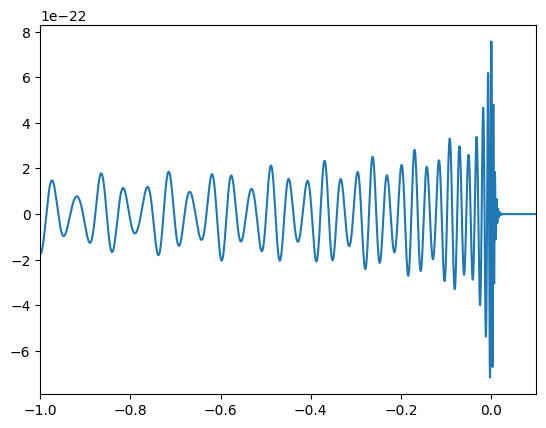

In [8]:
# Plot h0
h0_ts = harms[0].to_timeseries()
plt.plot(h0_ts.sample_times, h0_ts)
plt.xlim(-1, 0.1)
plt.show()

# Simple working example

In order to help diagnose this let's build a simple working example, just taking $n$ eccentric waveforms and combining them to form the dominant harmonic.

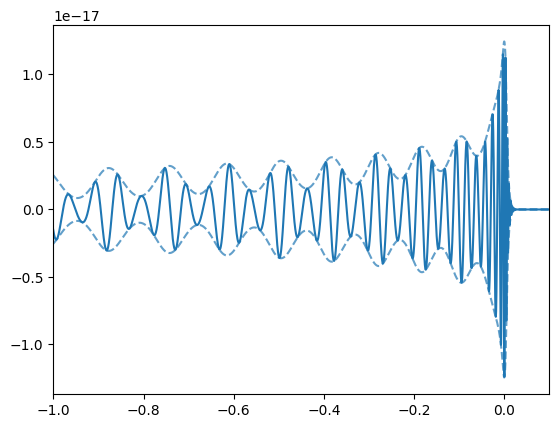

In [7]:
def teob_wf(M, q, e, chi1, chi2, f_gen, s_rate, phase=0,
            inclination=0, distance=1, f_ref_e=None,
            tlen=None, taper=True, to_fs=True,
            mode_array=[[2, 2]]):

    # Import teobresums
    try:
        import EOBRun_module
    except ImportError:
        print("Unable to import EOBRun_module, please check it is installed")
        return -1

    # Convert modes to teobresums convention
    if mode_array is None:
        mode_lm = [1]
    else:
        mode_lm = [int(x[0]*(x[0]-1)/2 + x[1]-2) for x in mode_array]

    # Convert eccentricity to correct frequency
    if f_ref_e is None:
        f_ref_e = f_gen
    else:
        e = shifted_e(f_gen, f_ref_e, e)

    # Convert Keplerian frequency to average frequency
    f_avg = f_gen*(1+e**2)/(1-e**2)**(3/2)

    # Generate waveform
    pars = {
        'M': M,
        'q': q,
        'chi1': chi1,
        'chi2': chi2,
        'LambdaAl2': 0.,
        'LambdaBl2': 0.,
        'ecc': e,
        'ecc_freq': 1,
        'domain': 0,
        'srate_interp': s_rate,
        'use_geometric_units': "no",
        'initial_frequency': f_avg,
        'interp_uniform_grid': "yes",
        'use_mode_lm': mode_lm,
        'arg_out': "yes",
        'distance': distance,
        'coalescence_angle': phase,
        'inclination': inclination
    }
    t, hp, hc, _, _ = EOBRun_module.EOBRunPy(pars)
    tmrg = t[np.argmax(np.abs(hp-1j*hc))]
    t = t - tmrg
    hp = TimeSeries(hp, t[1] - t[0], epoch=t[0])
    hc = TimeSeries(hc, t[1] - t[0], epoch=t[0])

    # Resize waveforms, taper, and return in requested domain
    if tlen is not None:
        hp.resize(tlen*s_rate)
        hc.resize(tlen*s_rate)
    if taper:
        hp = taper_timeseries(hp, tapermethod='start')
        hc = taper_timeseries(hc, tapermethod='start')
    if to_fs:
        hp = hp.to_frequencyseries()
        hc = hc.to_frequencyseries()
    return hp, hc

def get_comp_shifts_test(h, M, q, e, chi1, chi2, f_gen, s_rate, tlen, n_ecc_gen):

    s_f = shifted_f(f_gen, e, M, q)
    if e > 0:

        # Generate trial waveform shifted back by estimated 2pi in mean anomaly
        s_e = shifted_e(s_f, f_gen, e)
        s_wf_p, s_wf_c = teob_wf(M, q, s_e, chi1, chi2,
                         s_f, s_rate, tlen=tlen,
                         taper=False, to_fs=False)
        s_wf = s_wf_p - 1j*s_wf_c

        # Work out shift correction factor by examining peaks of both waveforms
        s_factor = compute_s_factor(h, s_wf)

    else:
        s_factor = 1
    if s_factor < 0.5 or s_factor > 2:
        raise RuntimeError('Unable to accurately identify how to shift '
                           'frequency and eccentricity for component '
                           'waveforms')

    # Finds shifted frequency and eccentricity of shifted waveforms
    max_s_f = f_gen - (f_gen - s_f)*s_factor
    if max_s_f <= 0:
        raise RuntimeError('Tried to generate component waveform with '
                           'negative starting frequency')
    s_f_vals = np.linspace(f_gen, max_s_f, n_ecc_gen, endpoint=False)[1:]
    s_e_vals = shifted_e(s_f_vals, f_gen, e)

    return s_f_vals, s_e_vals


def gen_component_wfs_test(M, q, e, chi1, chi2, f_gen, f_low, s_rate, phase,
                          inclination, distance, tlen, n_ecc_gen, psd=None):

    # Get psd into correct format if inputted
    if psd is not None:
        if type(psd) is dict:
            psd_dict = psd
        else:
            psd_dict = {'psd': psd}
        if tlen is None:
            tlen = int(1/psd_dict[list(psd_dict.keys())[0]].delta_f)

    # Calculates first component waveform and shifts required for others
    hp, hc = teob_wf(M, q, e, chi1, chi2, f_gen, s_rate,
             phase=phase, inclination=inclination,
             distance=distance, tlen=tlen,
             taper=False, to_fs=False)
    h = hp - 1j*hc
    s_f_vals, s_e_vals = get_comp_shifts_test(h, M, q, e, chi1, chi2, f_gen, s_rate,
                                              tlen, n_ecc_gen)

    # Taper first waveform
    h_taper_p = taper_timeseries(h.real(), tapermethod='start')
    h_taper_c = taper_timeseries(-h.imag(), tapermethod='start')
    h = h_taper_p - 1j*h_taper_c

    # Calculates psd if not inputted
    if psd is None:
        h.resize(2**np.ceil(np.log2(len(h))))
        delta_f = 1.0 / h.duration
        flen = len(h)//2 + 1
        psd_dict = {'psd': aLIGOZeroDetHighPower(flen, delta_f, f_low)}

    # Save first component waveform
    h_ts = h.sample_times
    h_dt = h.delta_t
    h_start = h.start_time
    comp_wfs = {key: [h] for key in psd_dict.keys()}

    # Generate all component waveforms
    for i in range(n_ecc_gen-1):

        # Create waveform
        hp, hc = teob_wf(M, q, s_e_vals[i], chi1, chi2,
                         s_f_vals[i], s_rate, phase=phase,
                         inclination=inclination,
                         distance=distance, tlen=tlen,
                         to_fs=False)
        h = hp - 1j*hc

        # Trim waveform to same size as first (shortest)
        wf_trim_interpolate = interp1d(h.sample_times, h, bounds_error=False,
                                       fill_value=0)
        wf_trim_strain = wf_trim_interpolate(h_ts)
        h = TimeSeries(wf_trim_strain, h_dt,
                       epoch=h_start)

        # Correct phase and taper for each psd
        for key in psd_dict.keys():
            overlap = overlap_cplx(h.real(), comp_wfs[key][0].real(),
                                   psd=psd_dict[key],
                                   low_frequency_cutoff=f_low,
                                   normalized=True)
            phase_angle = -np.angle(overlap)/2
            h_psd = h*np.exp(2*1j*phase_angle)

            # Re-taper waveform after trimming
            h_taper_p = taper_timeseries(h_psd.real(), tapermethod='start')
            h_taper_c = taper_timeseries(-h_psd.imag(), tapermethod='start')
            h_psd = h_taper_p - 1j*h_taper_c

            comp_wfs[key].append(h_psd)

    return comp_wfs, psd_dict

comp_wfs =  gen_component_wfs_test(60, 2, 0.4, 0, 0, 10, 10, 4096, 0,
                                   0, 1, 32, 20, psd=None)[0]['psd']
h0 = comp_wfs[0].copy()
for i in range(1, len(comp_wfs)):
    h0 += comp_wfs[i]
plt.plot(h0.sample_times, h0, c='C0')
plt.plot(h0.sample_times, np.abs(h0), c='C0', alpha=0.7, ls='dashed')
plt.plot(h0.sample_times, -np.abs(h0), c='C0', alpha=0.7, ls='dashed')
plt.xlim(-1, 0.1)
plt.show()

# Built-in TA argument

First idea is to test whether the built-in TA argument is useful to use. Believe it to be unlikely however will be quick to test.

In [9]:
def EA2MA(EA, e):
    MA = EA - e*np.sin(EA)
    return MA

def MA2EA(MA, e):
    bounds = [(0, 2*np.pi)]
    init_guess = MA
    best_fit = minimize(lambda x: np.abs(MA - EA2MA(x, e)), init_guess, bounds=bounds)
    EA = best_fit['x'][0]
    return EA

def EA2TA(EA, e):
    arg_num = np.sqrt(1+e)*np.sin(EA/2)
    arg_denom = np.sqrt(1-e)*np.cos(EA/2)
    TA = 2*np.arctan2(arg_num, arg_denom)
    return TA

def TA2EA(TA, e):
    arg_num = np.sqrt(1-e**2)*np.sin(TA)
    arg_denom = e+np.cos(TA)
    EA = np.arctan2(arg_num, arg_denom)
    EA = EA%(2*np.pi)
    return EA

def MA2TA(MA, e):
    TA = EA2TA(MA2EA(MA, e), e)
    return TA

def TA2MA(TA, e):
    MA = EA2MA(TA2EA(TA, e), e)
    return MA

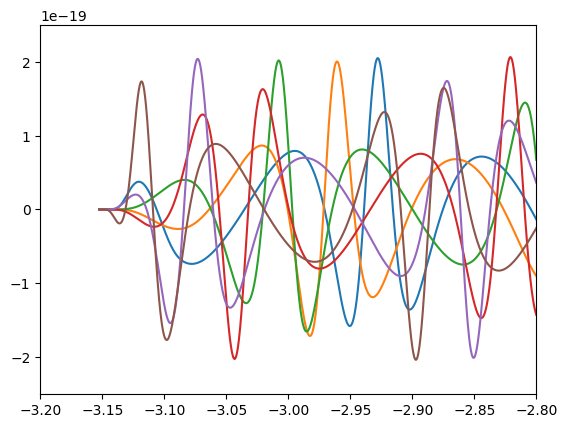

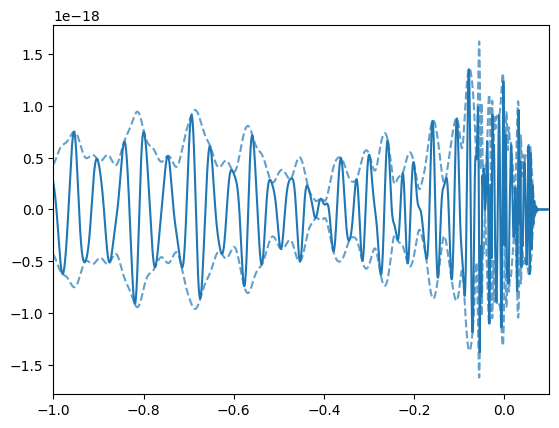

In [38]:
def teob_wf(M, q, e, chi1, chi2, f_gen, s_rate, TA=np.pi, phase=0,
            inclination=0, distance=1, f_ref_e=None,
            tlen=None, taper=True, to_fs=True,
            mode_array=[[2, 2]]):

    # Import teobresums
    try:
        import EOBRun_module
    except ImportError:
        print("Unable to import EOBRun_module, please check it is installed")
        return -1

    # Convert modes to teobresums convention
    if mode_array is None:
        mode_lm = [1]
    else:
        mode_lm = [int(x[0]*(x[0]-1)/2 + x[1]-2) for x in mode_array]

    # Convert eccentricity to correct frequency
    if f_ref_e is None:
        f_ref_e = f_gen
    else:
        e = shifted_e(f_gen, f_ref_e, e)

    # Convert Keplerian frequency to average frequency
    f_avg = f_gen*(1+e**2)/(1-e**2)**(3/2)

    # Generate waveform
    pars = {
        'M': M,
        'q': q,
        'chi1': chi1,
        'chi2': chi2,
        'LambdaAl2': 0.,
        'LambdaBl2': 0.,
        'ecc': e,
        'ecc_freq': 1,
        'domain': 0,
        'srate_interp': s_rate,
        'use_geometric_units': "no",
        'initial_frequency': f_avg,
        'interp_uniform_grid': "yes",
        'use_mode_lm': mode_lm,
        'arg_out': "yes",
        'distance': distance,
        'coalescence_angle': phase,
        'inclination': inclination,
        'anomaly': TA
    }
    t, hp, hc, _, _ = EOBRun_module.EOBRunPy(pars)
    tmrg = t[np.argmax(np.abs(hp-1j*hc))]
    t = t - tmrg
    hp = TimeSeries(hp, t[1] - t[0], epoch=t[0])
    hc = TimeSeries(hc, t[1] - t[0], epoch=t[0])

    # Resize waveforms, taper, and return in requested domain
    if tlen is not None:
        hp.resize(tlen*s_rate)
        hc.resize(tlen*s_rate)
    if taper:
        hp = taper_timeseries(hp, tapermethod='start')
        hc = taper_timeseries(hc, tapermethod='start')
    if to_fs:
        hp = hp.to_frequencyseries()
        hc = hc.to_frequencyseries()
    return hp, hc

# def get_comp_shifts_test(h, M, q, e, chi1, chi2, f_gen, s_rate, tlen, n_ecc_gen):

#     s_f = shifted_f(f_gen, e, M, q)
#     if e > 0:

#         # Generate trial waveform shifted back by estimated 2pi in mean anomaly
#         s_e = shifted_e(s_f, f_gen, e)
#         s_wf_p, s_wf_c = teob_wf(M, q, s_e, chi1, chi2,
#                          s_f, s_rate, tlen=tlen,
#                          taper=False, to_fs=False)
#         s_wf = s_wf_p - 1j*s_wf_c

#         # Work out shift correction factor by examining peaks of both waveforms
#         s_factor = compute_s_factor(h, s_wf)

#     else:
#         s_factor = 1
#     if s_factor < 0.5 or s_factor > 2:
#         raise RuntimeError('Unable to accurately identify how to shift '
#                            'frequency and eccentricity for component '
#                            'waveforms')

#     # Finds shifted frequency and eccentricity of shifted waveforms
#     max_s_f = f_gen - (f_gen - s_f)*s_factor
#     if max_s_f <= 0:
#         raise RuntimeError('Tried to generate component waveform with '
#                            'negative starting frequency')
#     s_f_vals = np.linspace(f_gen, max_s_f, n_ecc_gen, endpoint=False)[1:]
#     s_e_vals = shifted_e(s_f_vals, f_gen, e)

#     return s_f_vals, s_e_vals


def gen_component_wfs_test(M, q, e, chi1, chi2, f_gen, f_low, s_rate, phase,
                          inclination, distance, tlen, n_ecc_gen, psd=None):

    # Get psd into correct format if inputted
    if psd is not None:
        if type(psd) is dict:
            psd_dict = psd
        else:
            psd_dict = {'psd': psd}
        if tlen is None:
            tlen = int(1/psd_dict[list(psd_dict.keys())[0]].delta_f)

    # # Calculates first component waveform and shifts required for others
    # hp, hc = teob_wf(M, q, e, chi1, chi2, f_gen, s_rate,
    #          phase=phase, inclination=inclination,
    #          distance=distance, tlen=tlen,
    #          taper=False, to_fs=False)
    # h = hp - 1j*hc
    # s_f_vals, s_e_vals = get_comp_shifts_test(h, M, q, e, chi1, chi2, f_gen, s_rate,
    #                                           tlen, n_ecc_gen)

    # Calculate first waveform
    hp, hc = teob_wf(M, q, e, chi1, chi2, f_gen, s_rate, TA=0,
                     phase=phase, inclination=inclination,
                     distance=distance, tlen=tlen,
                     taper=False, to_fs=False)
    h = hp - 1j*hc

    # Taper first waveform
    h_taper_p = taper_timeseries(h.real(), tapermethod='start')
    h_taper_c = taper_timeseries(-h.imag(), tapermethod='start')
    h = h_taper_p - 1j*h_taper_c

    # Calculates psd if not inputted
    if psd is None:
        h.resize(2**np.ceil(np.log2(len(h))))
        delta_f = 1.0 / h.duration
        flen = len(h)//2 + 1
        psd_dict = {'psd': aLIGOZeroDetHighPower(flen, delta_f, f_low)}

    # Save first component waveform
    h_ts = h.sample_times
    h_dt = h.delta_t
    h_start = h.start_time
    comp_wfs = {key: [h] for key in psd_dict.keys()}

    # Generate all component waveforms
    for i in range(n_ecc_gen-1):

        # Create waveform
        MA = (i+1)*2*np.pi/n_ecc_gen
        TA = MA2TA(MA, e)
        hp, hc = teob_wf(M, q, e, chi1, chi2,
                         f_gen, s_rate, TA=TA, phase=phase,
                         inclination=inclination,
                         distance=distance, tlen=tlen,
                         to_fs=False)
        h = hp - 1j*hc

        # Add each component waveform
        for key in psd_dict.keys():
            comp_wfs[key].append(h)

    # Shift component waveforms to align at start
    for key in comp_wfs.keys():
        epoch_avg = np.mean([comp_wfs[key][i].start_time for i in range(len(comp_wfs[key]))])
        for i in range(n_ecc_gen):
            comp_wfs[key][i].start_time = epoch_avg

    # Align all component waveform phases
    for key in comp_wfs.keys():
        for i in range(1,n_ecc_gen):
            overlap = overlap_cplx(comp_wfs[key][i].real(), comp_wfs[key][0].real(),
                                   psd=psd_dict[key],
                                   low_frequency_cutoff=f_low,
                                   normalized=True)
            phase_angle = -np.angle(overlap)/2
            comp_wfs[key][i] *= np.exp(2*1j*phase_angle)

    return comp_wfs, psd_dict

# Generate component waveforms
comp_wfs =  gen_component_wfs_test(60, 2, 0.4, 0, 0, 10, 10, 4096, 0,
                                   0, 1, 32, 6, psd=None)[0]['psd']

# Plot component waveforms
for i in range(len(comp_wfs)):
    plt.plot(comp_wfs[i].sample_times, comp_wfs[i], c=f'C{i}')
plt.xlim(-3.2, -2.8)
plt.ylim(-2.5e-19, 2.5e-19)
plt.show()

# Plot dominant harmonic
h0 = comp_wfs[0].copy()
for i in range(1, len(comp_wfs)):
    h0 += comp_wfs[i]
plt.plot(h0.sample_times, h0, c='C0')
plt.plot(h0.sample_times, np.abs(h0), c='C0', alpha=0.7, ls='dashed')
plt.plot(h0.sample_times, -np.abs(h0), c='C0', alpha=0.7, ls='dashed')
plt.xlim(-1, 0.1)
plt.show()

Testing equally spaced in TA and MA, neither helps us. Finally, trying to equally space in MA but then align start times results in a jumbled mess for the dominant harmonic.

## Equal spacing with evolution

Next idea is to see if taking evolution into account when creating 'equally spaced' waveforms is important.

Calculating the actual evolution is tricky, so for now let's see if we can 'bruteforce' a spacing which helps. We will do this by allowing the 'position' of the component waveforms to vary in each direction by 25% of the gap to the next waveform. We can then quantify the presence of modulations by finding the 'monotonicity' of the first few seconds of the envelope using the spearman rank correlation coefficient, and optimising this with scipy.optimize.minimize.

      fun: -0.5940460983311718
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -4.07746713,  -7.18488077,  12.89711767, -21.67150807,
         3.43031445])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 252
      nit: 6
     njev: 42
   status: 0
  success: True
        x: array([ 9.45687099e-06, -2.09509588e-03,  2.17030506e-03,
       -9.70358544e-07, -2.16546297e-03])


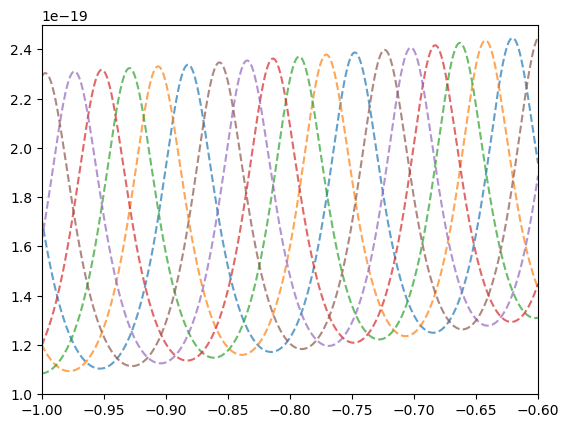

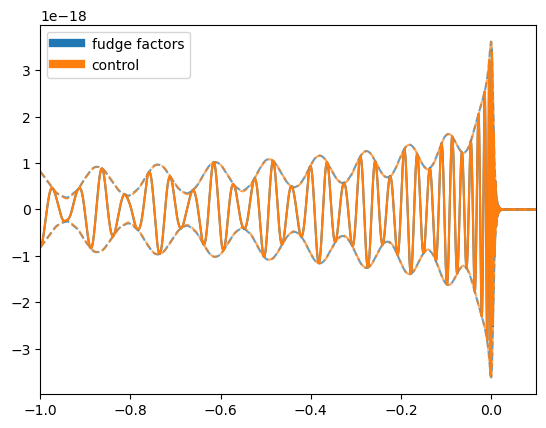

In [76]:
def teob_wf(M, q, e, chi1, chi2, f_gen, s_rate, phase=0,
            inclination=0, distance=1, f_ref_e=None,
            tlen=None, taper=True, to_fs=True,
            mode_array=[[2, 2]]):

    # Import teobresums
    try:
        import EOBRun_module
    except ImportError:
        print("Unable to import EOBRun_module, please check it is installed")
        return -1

    # Convert modes to teobresums convention
    if mode_array is None:
        mode_lm = [1]
    else:
        mode_lm = [int(x[0]*(x[0]-1)/2 + x[1]-2) for x in mode_array]

    # Convert eccentricity to correct frequency
    if f_ref_e is None:
        f_ref_e = f_gen
    else:
        e = shifted_e(f_gen, f_ref_e, e)

    # Convert Keplerian frequency to average frequency
    f_avg = f_gen*(1+e**2)/(1-e**2)**(3/2)

    # Generate waveform
    pars = {
        'M': M,
        'q': q,
        'chi1': chi1,
        'chi2': chi2,
        'LambdaAl2': 0.,
        'LambdaBl2': 0.,
        'ecc': e,
        'ecc_freq': 1,
        'domain': 0,
        'srate_interp': s_rate,
        'use_geometric_units': "no",
        'initial_frequency': f_avg,
        'interp_uniform_grid': "yes",
        'use_mode_lm': mode_lm,
        'arg_out': "yes",
        'distance': distance,
        'coalescence_angle': phase,
        'inclination': inclination
    }
    t, hp, hc, _, _ = EOBRun_module.EOBRunPy(pars)
    tmrg = t[np.argmax(np.abs(hp-1j*hc))]
    t = t - tmrg
    hp = TimeSeries(hp, t[1] - t[0], epoch=t[0])
    hc = TimeSeries(hc, t[1] - t[0], epoch=t[0])

    # Resize waveforms, taper, and return in requested domain
    if tlen is not None:
        hp.resize(tlen*s_rate)
        hc.resize(tlen*s_rate)
    if taper:
        hp = taper_timeseries(hp, tapermethod='start')
        hc = taper_timeseries(hc, tapermethod='start')
    if to_fs:
        hp = hp.to_frequencyseries()
        hc = hc.to_frequencyseries()
    return hp, hc

def get_comp_shifts_test(fudge_fs, h, M, q, e, chi1, chi2, f_gen, s_rate, tlen, n_ecc_gen):

    s_f = shifted_f(f_gen, e, M, q)
    if e > 0:

        # Generate trial waveform shifted back by estimated 2pi in mean anomaly
        s_e = shifted_e(s_f, f_gen, e)
        s_wf_p, s_wf_c = teob_wf(M, q, s_e, chi1, chi2,
                         s_f, s_rate, tlen=tlen,
                         taper=False, to_fs=False)
        s_wf = s_wf_p - 1j*s_wf_c

        # Work out shift correction factor by examining peaks of both waveforms
        s_factor = compute_s_factor(h, s_wf)

    else:
        s_factor = 1
    if s_factor < 0.5 or s_factor > 2:
        raise RuntimeError('Unable to accurately identify how to shift '
                           'frequency and eccentricity for component '
                           'waveforms')

    # Finds shifted frequency and eccentricity of shifted waveforms
    max_s_f = f_gen - (f_gen - s_f)*s_factor
    if max_s_f <= 0:
        raise RuntimeError('Tried to generate component waveform with '
                           'negative starting frequency')
    s_f_2pi = f_gen - max_s_f
    s_f_vals = []
    for i in range(1, n_ecc_gen):      
        s_f_vals.append(f_gen - (i+fudge_fs[i-1])*s_f_2pi/n_ecc_gen)
    s_f_vals = np.array(s_f_vals)
    s_e_vals = shifted_e(s_f_vals, f_gen, e)

    return s_f_vals, s_e_vals


def gen_component_wfs_test(fudge_fs, M, q, e, chi1, chi2, f_gen, f_low, s_rate, phase,
                           inclination, distance, tlen, n_ecc_gen, psd=None):

    # Get psd into correct format if inputted
    if psd is not None:
        if type(psd) is dict:
            psd_dict = psd
        else:
            psd_dict = {'psd': psd}
        if tlen is None:
            tlen = int(1/psd_dict[list(psd_dict.keys())[0]].delta_f)

    # Calculates first component waveform and shifts required for others
    hp, hc = teob_wf(M, q, e, chi1, chi2, f_gen, s_rate,
             phase=phase, inclination=inclination,
             distance=distance, tlen=tlen,
             taper=False, to_fs=False)
    h = hp - 1j*hc
    s_f_vals, s_e_vals = get_comp_shifts_test(fudge_fs, h, M, q, e, chi1, chi2, f_gen, s_rate,
                                              tlen, n_ecc_gen)

    # Taper first waveform
    h_taper_p = taper_timeseries(h.real(), tapermethod='start')
    h_taper_c = taper_timeseries(-h.imag(), tapermethod='start')
    h = h_taper_p - 1j*h_taper_c

    # Calculates psd if not inputted
    if psd is None:
        h.resize(2**np.ceil(np.log2(len(h))))
        delta_f = 1.0 / h.duration
        flen = len(h)//2 + 1
        psd_dict = {'psd': aLIGOZeroDetHighPower(flen, delta_f, f_low)}

    # Save first component waveform
    h_ts = h.sample_times
    h_dt = h.delta_t
    h_start = h.start_time
    comp_wfs = {key: [h] for key in psd_dict.keys()}

    # Generate all component waveforms
    for i in range(n_ecc_gen-1):

        # Create waveform
        hp, hc = teob_wf(M, q, s_e_vals[i], chi1, chi2,
                         s_f_vals[i], s_rate, phase=phase,
                         inclination=inclination,
                         distance=distance, tlen=tlen,
                         to_fs=False)
        h = hp - 1j*hc

        # Trim waveform to same size as first (shortest)
        wf_trim_interpolate = interp1d(h.sample_times, h, bounds_error=False,
                                       fill_value=0)
        wf_trim_strain = wf_trim_interpolate(h_ts)
        h = TimeSeries(wf_trim_strain, h_dt,
                       epoch=h_start)

        # Correct phase and taper for each psd
        for key in psd_dict.keys():
            overlap = overlap_cplx(h.real(), comp_wfs[key][0].real(),
                                   psd=psd_dict[key],
                                   low_frequency_cutoff=f_low,
                                   normalized=True)
            phase_angle = -np.angle(overlap)/2
            h_psd = h*np.exp(2*1j*phase_angle)

            # Re-taper waveform after trimming
            h_taper_p = taper_timeseries(h_psd.real(), tapermethod='start')
            h_taper_c = taper_timeseries(-h_psd.imag(), tapermethod='start')
            h_psd = h_taper_p - 1j*h_taper_c

            comp_wfs[key].append(h_psd)

    return comp_wfs, psd_dict

def spearman_min(fudge_fs, n_ecc_gen):
    comp_wfs =  gen_component_wfs_test(fudge_fs, 60, 2, 0.4, 0, 0, 10, 10, 4096, 0,
                                       0, 1, 32, n_ecc_gen)[0]['psd']
    h0 = comp_wfs[0].copy()
    for i in range(1, len(comp_wfs)):
        h0 += comp_wfs[i]
    cutoff_ind = np.argmin(np.abs(h0.sample_times+0.2))
    spearman = spearmanr(np.abs(h0)[:cutoff_ind], h0.sample_times[:cutoff_ind])[0]
    return spearman

# Perform minimization
n_ecc_gen = 6
bounds = [(-0.25, 0.25) for i in range(n_ecc_gen-1)]
init_guess = np.zeros(n_ecc_gen-1)
best_fit = minimize(lambda x: -spearman_min(x, n_ecc_gen), init_guess, bounds=bounds)
print(best_fit)
comp_wfs =  gen_component_wfs_test(best_fit['x'], 60, 2, 0.4, 0, 0, 10, 10, 4096, 0,
                                    0, 1, 32, n_ecc_gen, psd=None)[0]['psd']

# Plot component waveforms
for i in range(len(comp_wfs)):
    plt.plot(comp_wfs[i].sample_times, np.abs(comp_wfs[i]), c=f'C{i}', alpha=0.7, ls='dashed')
plt.xlim(-1, -0.6)
plt.ylim(1e-19, 2.5e-19)
plt.show()

# Plot dominant harmonic
h0 = comp_wfs[0].copy()
for i in range(1, len(comp_wfs)):
    h0 += comp_wfs[i]
plt.plot(h0.sample_times, h0, c='C0', label='fudge factors')
plt.plot(h0.sample_times, np.abs(h0), c='C0', alpha=0.7, ls='dashed')
plt.plot(h0.sample_times, -np.abs(h0), c='C0', alpha=0.7, ls='dashed')


# Plot control dominant harmonic
comp_wfs =  gen_component_wfs_test([0]*(n_ecc_gen-1), 60, 2, 0.4, 0, 0, 10, 10, 4096, 0,
                                   0, 1, 32, n_ecc_gen, psd=None)[0]['psd']
h0 = comp_wfs[0].copy()
for i in range(1, len(comp_wfs)):
    h0 += comp_wfs[i]
plt.plot(h0.sample_times, h0, c='C1', label='control')
plt.plot(h0.sample_times, np.abs(h0), c='C1', alpha=0.7, ls='dashed')
plt.plot(h0.sample_times, -np.abs(h0), c='C1', alpha=0.7, ls='dashed')
plt.legend()
plt.xlim(-1, 0.1)
plt.show()

# SVD

Let's make an SVD for 6 component waveforms and ecc=0.4 to see if it can improve on our current method of combining 6 component waveforms. Important to note however that SVD does not care about making dominant harmonic circular.

## 6 components

In [7]:
def teob_wf(M, q, e, chi1, chi2, f_gen, s_rate, phase=0,
            inclination=0, distance=1, f_ref_e=None,
            tlen=None, taper=True, to_fs=True,
            mode_array=[[2, 2]]):

    # Import teobresums
    try:
        import EOBRun_module
    except ImportError:
        print("Unable to import EOBRun_module, please check it is installed")
        return -1

    # Convert modes to teobresums convention
    if mode_array is None:
        mode_lm = [1]
    else:
        mode_lm = [int(x[0]*(x[0]-1)/2 + x[1]-2) for x in mode_array]

    # Convert eccentricity to correct frequency
    if f_ref_e is None:
        f_ref_e = f_gen
    else:
        e = shifted_e(f_gen, f_ref_e, e)

    # Convert Keplerian frequency to average frequency
    f_avg = f_gen*(1+e**2)/(1-e**2)**(3/2)

    # Generate waveform
    pars = {
        'M': M,
        'q': q,
        'chi1': chi1,
        'chi2': chi2,
        'LambdaAl2': 0.,
        'LambdaBl2': 0.,
        'ecc': e,
        'ecc_freq': 1,
        'domain': 0,
        'srate_interp': s_rate,
        'use_geometric_units': "no",
        'initial_frequency': f_avg,
        'interp_uniform_grid': "yes",
        'use_mode_lm': mode_lm,
        'arg_out': "yes",
        'distance': distance,
        'coalescence_angle': phase,
        'inclination': inclination
    }
    t, hp, hc, _, _ = EOBRun_module.EOBRunPy(pars)
    tmrg = t[np.argmax(np.abs(hp-1j*hc))]
    t = t - tmrg
    hp = TimeSeries(hp, t[1] - t[0], epoch=t[0])
    hc = TimeSeries(hc, t[1] - t[0], epoch=t[0])

    # Resize waveforms, taper, and return in requested domain
    if tlen is not None:
        hp.resize(tlen*s_rate)
        hc.resize(tlen*s_rate)
    if taper:
        hp = taper_timeseries(hp, tapermethod='start')
        hc = taper_timeseries(hc, tapermethod='start')
    if to_fs:
        hp = hp.to_frequencyseries()
        hc = hc.to_frequencyseries()
    return hp, hc

def get_comp_shifts_test(h, M, q, e, chi1, chi2, f_gen, s_rate, tlen, n_ecc_gen):

    s_f = shifted_f(f_gen, e, M, q)
    if e > 0:

        # Generate trial waveform shifted back by estimated 2pi in mean anomaly
        s_e = shifted_e(s_f, f_gen, e)
        s_wf_p, s_wf_c = teob_wf(M, q, s_e, chi1, chi2,
                         s_f, s_rate, tlen=tlen,
                         taper=False, to_fs=False)
        s_wf = s_wf_p - 1j*s_wf_c

        # Work out shift correction factor by examining peaks of both waveforms
        s_factor = compute_s_factor(h, s_wf)

    else:
        s_factor = 1
    if s_factor < 0.5 or s_factor > 2:
        raise RuntimeError('Unable to accurately identify how to shift '
                           'frequency and eccentricity for component '
                           'waveforms')

    # Finds shifted frequency and eccentricity of shifted waveforms
    max_s_f = f_gen - (f_gen - s_f)*s_factor
    if max_s_f <= 0:
        raise RuntimeError('Tried to generate component waveform with '
                           'negative starting frequency')
    s_f_vals = np.linspace(f_gen, max_s_f, n_ecc_gen, endpoint=False)[1:]
    s_e_vals = shifted_e(s_f_vals, f_gen, e)

    return s_f_vals, s_e_vals


def gen_component_wfs_test(M, q, e, chi1, chi2, f_gen, f_low, s_rate, phase,
                          inclination, distance, tlen, n_ecc_gen, psd=None):

    # Get psd into correct format if inputted
    if psd is not None:
        if type(psd) is dict:
            psd_dict = psd
        else:
            psd_dict = {'psd': psd}
        if tlen is None:
            tlen = int(1/psd_dict[list(psd_dict.keys())[0]].delta_f)

    # Calculates first component waveform and shifts required for others
    hp, hc = teob_wf(M, q, e, chi1, chi2, f_gen, s_rate,
             phase=phase, inclination=inclination,
             distance=distance, tlen=tlen,
             taper=False, to_fs=False)
    h = hp - 1j*hc
    s_f_vals, s_e_vals = get_comp_shifts_test(h, M, q, e, chi1, chi2, f_gen, s_rate,
                                              tlen, n_ecc_gen)

    # Taper first waveform
    h_taper_p = taper_timeseries(h.real(), tapermethod='start')
    h_taper_c = taper_timeseries(-h.imag(), tapermethod='start')
    h = h_taper_p - 1j*h_taper_c

    # Calculates psd if not inputted
    if psd is None:
        h.resize(2**np.ceil(np.log2(len(h))))
        delta_f = 1.0 / h.duration
        flen = len(h)//2 + 1
        psd_dict = {'psd': aLIGOZeroDetHighPower(flen, delta_f, f_low)}

    # Save first component waveform
    h_ts = h.sample_times
    h_dt = h.delta_t
    h_start = h.start_time
    comp_wfs = {key: [h] for key in psd_dict.keys()}

    # Generate all component waveforms
    for i in range(n_ecc_gen-1):

        # Create waveform
        hp, hc = teob_wf(M, q, s_e_vals[i], chi1, chi2,
                         s_f_vals[i], s_rate, phase=phase,
                         inclination=inclination,
                         distance=distance, tlen=tlen,
                         to_fs=False)
        h = hp - 1j*hc

        # Trim waveform to same size as first (shortest)
        wf_trim_interpolate = interp1d(h.sample_times, h, bounds_error=False,
                                       fill_value=0)
        wf_trim_strain = wf_trim_interpolate(h_ts)
        h = TimeSeries(wf_trim_strain, h_dt,
                       epoch=h_start)

        # Correct phase and taper for each psd
        for key in psd_dict.keys():
            overlap = overlap_cplx(h.real(), comp_wfs[key][0].real(),
                                   psd=psd_dict[key],
                                   low_frequency_cutoff=f_low,
                                   normalized=True)
            phase_angle = -np.angle(overlap)/2
            h_psd = h*np.exp(2*1j*phase_angle)

            # Re-taper waveform after trimming
            h_taper_p = taper_timeseries(h_psd.real(), tapermethod='start')
            h_taper_c = taper_timeseries(-h_psd.imag(), tapermethod='start')
            h_psd = h_taper_p - 1j*h_taper_c

            comp_wfs[key].append(h_psd)

    return comp_wfs, psd_dict

comp_wfs =  gen_component_wfs_test(60, 2, 0.4, 0, 0, 10, 10, 4096, 0,
                                   0, 1, 8, 6, psd=None)[0]['psd']

# Convert comp wf data to np array in right shape/form and calculate svd
print('Starting SVD calculation')
start = time.time()
X = np.array(comp_wfs)
means = X.mean(axis=1)
stds = X.std(axis=1)
Uh, S, V = np.linalg.svd(((X.T-means)/stds).T)
end = time.time()
print(f'Time taken: {end-start} seconds')

Starting SVD calculation
Time taken: 82.84776663780212 seconds


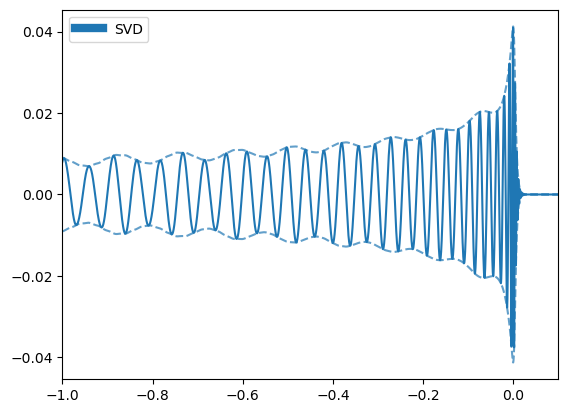

In [34]:
plt.plot(comp_wfs[0].sample_times, V[0], c='C0', label='SVD')
plt.plot(comp_wfs[0].sample_times, np.abs(V[0]), c='C0', alpha=0.7, ls='dashed')
plt.plot(comp_wfs[0].sample_times, -np.abs(V[0]), c='C0', alpha=0.7, ls='dashed')
# h0 = comp_wfs[0].copy()
# for i in range(1, len(comp_wfs)):
#     h0 += comp_wfs[i]
# h0 /= np.std(h0)
# plt.plot(h0.sample_times, h0, c='C1', label='us')
# plt.plot(h0.sample_times, np.abs(h0), c='C1', alpha=0.7, ls='dashed')
# plt.plot(h0.sample_times, -np.abs(h0), c='C1', alpha=0.7, ls='dashed')
plt.legend()
plt.xlim(-1, 0.1)
plt.show()

This is already visibly much lower amplitude modulations, so let's see the coefficients that have produced this.

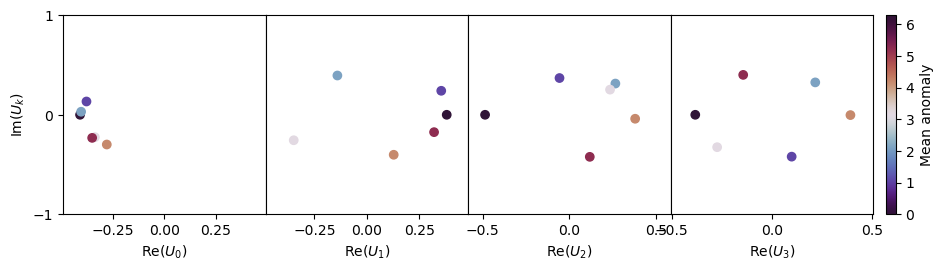

In [43]:
# Make plot
n_comp = 4
lim_mod = 1.2
f = plt.figure(figsize=(6.4*1.5, 3.75*0.75))
widths = np.ones(n_comp)
widths[-1] += 0.25
f.subplots(1, n_comp, gridspec_kw={'width_ratios': widths, 'wspace': 0}, sharey=True)
colors = np.linspace(0, 2*np.pi, 6, endpoint=False)
U = np.conj(Uh).T
for i in range(n_comp):
    plt.subplot(1, n_comp, i+1)
    plt.scatter(np.real(U[i]), np.imag(U[i]), c=colors, vmin=0, vmax=2*np.pi, cmap='twilight_shifted')
    xlim = np.max(np.abs(np.real(U[i])))
    ylim = np.max(np.abs(np.imag(U[i])))
    lim = lim_mod*np.max([xlim, ylim])
    plt.xlim(-lim, lim)
    plt.ylim(-lim, lim)
    plt.xlabel(r'Re($U_%d$)' % i)
    if i == 0:
        plt.ylabel('Im($U_k$)')
    else:
        plt.gca().get_yaxis().set_visible(False)

# Plot formatting
plt.yticks([-1,0,1])
plt.colorbar(label='Mean anomaly')
plt.tight_layout()
plt.show()

These patterns are not at all clear, and quite noisy. Let's repeat with a much higher number of component waveforms.

## 500 components

In [46]:
def teob_wf(M, q, e, chi1, chi2, f_gen, s_rate, phase=0,
            inclination=0, distance=1, f_ref_e=None,
            tlen=None, taper=True, to_fs=True,
            mode_array=[[2, 2]]):

    # Import teobresums
    try:
        import EOBRun_module
    except ImportError:
        print("Unable to import EOBRun_module, please check it is installed")
        return -1

    # Convert modes to teobresums convention
    if mode_array is None:
        mode_lm = [1]
    else:
        mode_lm = [int(x[0]*(x[0]-1)/2 + x[1]-2) for x in mode_array]

    # Convert eccentricity to correct frequency
    if f_ref_e is None:
        f_ref_e = f_gen
    else:
        e = shifted_e(f_gen, f_ref_e, e)

    # Convert Keplerian frequency to average frequency
    f_avg = f_gen*(1+e**2)/(1-e**2)**(3/2)

    # Generate waveform
    pars = {
        'M': M,
        'q': q,
        'chi1': chi1,
        'chi2': chi2,
        'LambdaAl2': 0.,
        'LambdaBl2': 0.,
        'ecc': e,
        'ecc_freq': 1,
        'domain': 0,
        'srate_interp': s_rate,
        'use_geometric_units': "no",
        'initial_frequency': f_avg,
        'interp_uniform_grid': "yes",
        'use_mode_lm': mode_lm,
        'arg_out': "yes",
        'distance': distance,
        'coalescence_angle': phase,
        'inclination': inclination
    }
    t, hp, hc, _, _ = EOBRun_module.EOBRunPy(pars)
    tmrg = t[np.argmax(np.abs(hp-1j*hc))]
    t = t - tmrg
    hp = TimeSeries(hp, t[1] - t[0], epoch=t[0])
    hc = TimeSeries(hc, t[1] - t[0], epoch=t[0])

    # Resize waveforms, taper, and return in requested domain
    if tlen is not None:
        hp.resize(tlen*s_rate)
        hc.resize(tlen*s_rate)
    if taper:
        hp = taper_timeseries(hp, tapermethod='start')
        hc = taper_timeseries(hc, tapermethod='start')
    if to_fs:
        hp = hp.to_frequencyseries()
        hc = hc.to_frequencyseries()
    return hp, hc

def get_comp_shifts_test(h, M, q, e, chi1, chi2, f_gen, s_rate, tlen, n_ecc_gen):

    s_f = shifted_f(f_gen, e, M, q)
    if e > 0:

        # Generate trial waveform shifted back by estimated 2pi in mean anomaly
        s_e = shifted_e(s_f, f_gen, e)
        s_wf_p, s_wf_c = teob_wf(M, q, s_e, chi1, chi2,
                         s_f, s_rate, tlen=tlen,
                         taper=False, to_fs=False)
        s_wf = s_wf_p - 1j*s_wf_c

        # Work out shift correction factor by examining peaks of both waveforms
        s_factor = compute_s_factor(h, s_wf)

    else:
        s_factor = 1
    if s_factor < 0.5 or s_factor > 2:
        raise RuntimeError('Unable to accurately identify how to shift '
                           'frequency and eccentricity for component '
                           'waveforms')

    # Finds shifted frequency and eccentricity of shifted waveforms
    max_s_f = f_gen - (f_gen - s_f)*s_factor
    if max_s_f <= 0:
        raise RuntimeError('Tried to generate component waveform with '
                           'negative starting frequency')
    s_f_vals = np.linspace(f_gen, max_s_f, n_ecc_gen, endpoint=False)[1:]
    s_e_vals = shifted_e(s_f_vals, f_gen, e)

    return s_f_vals, s_e_vals


def gen_component_wfs_test(M, q, e, chi1, chi2, f_gen, f_low, s_rate, phase,
                          inclination, distance, tlen, n_ecc_gen, psd=None):

    # Get psd into correct format if inputted
    if psd is not None:
        if type(psd) is dict:
            psd_dict = psd
        else:
            psd_dict = {'psd': psd}
        if tlen is None:
            tlen = int(1/psd_dict[list(psd_dict.keys())[0]].delta_f)

    # Calculates first component waveform and shifts required for others
    hp, hc = teob_wf(M, q, e, chi1, chi2, f_gen, s_rate,
             phase=phase, inclination=inclination,
             distance=distance, tlen=tlen,
             taper=False, to_fs=False)
    h = hp - 1j*hc
    s_f_vals, s_e_vals = get_comp_shifts_test(h, M, q, e, chi1, chi2, f_gen, s_rate,
                                              tlen, n_ecc_gen)

    # Taper first waveform
    h_taper_p = taper_timeseries(h.real(), tapermethod='start')
    h_taper_c = taper_timeseries(-h.imag(), tapermethod='start')
    h = h_taper_p - 1j*h_taper_c

    # Calculates psd if not inputted
    if psd is None:
        h.resize(2**np.ceil(np.log2(len(h))))
        delta_f = 1.0 / h.duration
        flen = len(h)//2 + 1
        psd_dict = {'psd': aLIGOZeroDetHighPower(flen, delta_f, f_low)}

    # Save first component waveform
    h_ts = h.sample_times
    h_dt = h.delta_t
    h_start = h.start_time
    comp_wfs = {key: [h] for key in psd_dict.keys()}

    # Generate all component waveforms
    for i in range(n_ecc_gen-1):

        # Create waveform
        hp, hc = teob_wf(M, q, s_e_vals[i], chi1, chi2,
                         s_f_vals[i], s_rate, phase=phase,
                         inclination=inclination,
                         distance=distance, tlen=tlen,
                         to_fs=False)
        h = hp - 1j*hc

        # Trim waveform to same size as first (shortest)
        wf_trim_interpolate = interp1d(h.sample_times, h, bounds_error=False,
                                       fill_value=0)
        wf_trim_strain = wf_trim_interpolate(h_ts)
        h = TimeSeries(wf_trim_strain, h_dt,
                       epoch=h_start)

        # Correct phase and taper for each psd
        for key in psd_dict.keys():
            overlap = overlap_cplx(h.real(), comp_wfs[key][0].real(),
                                   psd=psd_dict[key],
                                   low_frequency_cutoff=f_low,
                                   normalized=True)
            phase_angle = -np.angle(overlap)/2
            h_psd = h*np.exp(2*1j*phase_angle)

            # Re-taper waveform after trimming
            h_taper_p = taper_timeseries(h_psd.real(), tapermethod='start')
            h_taper_c = taper_timeseries(-h_psd.imag(), tapermethod='start')
            h_psd = h_taper_p - 1j*h_taper_c

            comp_wfs[key].append(h_psd)

        print(f'\r{i} waveforms generated out of {n_ecc_gen}', end='')
    print('')

    return comp_wfs, psd_dict

comp_wfs =  gen_component_wfs_test(60, 2, 0.4, 0, 0, 10, 10, 4096, 0,
                                   0, 1, 8, 500, psd=None)[0]['psd']

# Convert comp wf data to np array in right shape/form and calculate svd
print('Starting SVD calculation')
start = time.time()
X = np.array(comp_wfs)
means = X.mean(axis=1)
stds = X.std(axis=1)
Uh, S, V = np.linalg.svd(((X.T-means)/stds).T)
end = time.time()
print(f'Time taken: {end-start} seconds')

498 waveforms generated out of 500
Starting SVD calculation
Time taken: 238.61304092407227 seconds


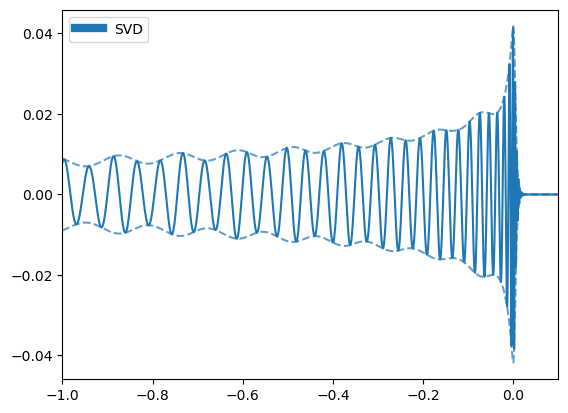

In [47]:
plt.plot(comp_wfs[0].sample_times, V[0], c='C0', label='SVD')
plt.plot(comp_wfs[0].sample_times, np.abs(V[0]), c='C0', alpha=0.7, ls='dashed')
plt.plot(comp_wfs[0].sample_times, -np.abs(V[0]), c='C0', alpha=0.7, ls='dashed')
# h0 = comp_wfs[0].copy()
# for i in range(1, len(comp_wfs)):
#     h0 += comp_wfs[i]
# h0 /= np.std(h0)
# plt.plot(h0.sample_times, h0, c='C1', label='us')
# plt.plot(h0.sample_times, np.abs(h0), c='C1', alpha=0.7, ls='dashed')
# plt.plot(h0.sample_times, -np.abs(h0), c='C1', alpha=0.7, ls='dashed')
plt.legend()
plt.xlim(-1, 0.1)
plt.show()

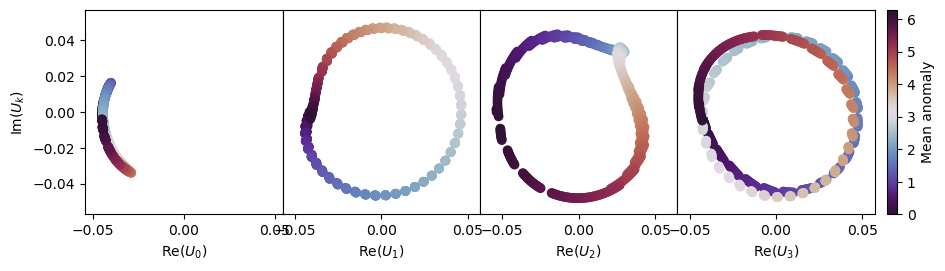

In [49]:
# Make plot
n_comp = 4
lim_mod = 1.2
f = plt.figure(figsize=(6.4*1.5, 3.75*0.75))
widths = np.ones(n_comp)
widths[-1] += 0.25
f.subplots(1, n_comp, gridspec_kw={'width_ratios': widths, 'wspace': 0}, sharey=True)
colors = np.linspace(0, 2*np.pi, 500, endpoint=False)
U = np.conj(Uh).T
for i in range(n_comp):
    plt.subplot(1, n_comp, i+1)
    plt.scatter(np.real(U[i]), np.imag(U[i]), c=colors, vmin=0, vmax=2*np.pi, cmap='twilight_shifted')
    xlim = np.max(np.abs(np.real(U[i])))
    ylim = np.max(np.abs(np.imag(U[i])))
    lim = lim_mod*np.max([xlim, ylim])
    plt.xlim(-lim, lim)
    plt.ylim(-lim, lim)
    plt.xlabel(r'Re($U_%d$)' % i)
    if i == 0:
        plt.ylabel('Im($U_k$)')
    else:
        plt.gca().get_yaxis().set_visible(False)

# Plot formatting
plt.colorbar(label='Mean anomaly')
plt.tight_layout()
plt.show()